Import packages

In [154]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import easygui as eg
import numpy as np
from ipywidgets import interact

Load brightspace files

In [138]:
df1 = pd.read_excel('metaClean43Brightspace.xlsx')
df2 = pd.read_excel('sales.xlsx')
df3 = pd.read_excel('ExpertReviewsClean43LIWC.xlsx')
df4 = pd.read_excel('UserReviewsClean43LIWC.xlsx')

Copy dataframes

In [139]:
movies_df = df1.copy()
sales_df = df2.copy()
cr_df = df3.copy()
ur_df = df4.copy()

Movies file data cleaning

In [140]:
# Drop not used columns
movies_df.drop(columns=['studio', 'rating', 'runtime', 'cast', 'director', 'summary', 'awards'])

# Add a movie_id column
movies_df['movie_id'] = range(1, len(movies_df) + 1)

# Rearrange the columns 
movies_df = movies_df[['movie_id', 'title', 'genre', 'metascore', 'userscore', 'url']]

# Drop duplicates
movies_df = movies_df.drop_duplicates(subset='title')


Sales file cleaning

In [141]:
# Drop not used columns
sales_df = sales_df.drop(columns=["year", "release_date", "international_box_office", "domestic_box_office", "Unnamed: 8", "avg run per theatre", "runtime", "keywords", "creative_type"])

# Add a sales_id column
sales_df["sales_id"] = range(1, len(sales_df) +1)

# Rearange the columns
sales_df = sales_df[['sales_id', 'title', 'genre', 'url', 'worldwide_box_office', 'production_budget', 'opening_weekend', 'theatre_count']]

# Drop duplicates
sales_df = sales_df.drop_duplicates(subset='title')

User review file cleaning

In [142]:
# Drop duplicates
ur_df.drop_duplicates(subset='Rev', inplace=True)

# Drop not used columns
ur_df = ur_df[['url', 'idvscore', 'dateP']]

# Add a us_id column
ur_df['ur_id'] = range(1, len(ur_df) + 1)

# Rearrange the columns
ur_df = ur_df[['ur_id', 'url', 'idvscore', 'dateP']]

Critical review file cleaning

In [143]:
# Drop duplicates
cr_df.drop_duplicates(subset='Rev', inplace=True)

# Drop not used columns
cr_df = cr_df[['url', 'idvscore', 'dateP']]

# Add a us_id column
cr_df['cr_id'] = range(1, len(cr_df) + 1)

# Rearrange the columns
cr_df = cr_df[['cr_id', 'url', 'idvscore', 'dateP']]

Create dataframe of unique genres

In [144]:
# Merge the DataFrames including genre columns
genre_df = movies_df.merge(sales_df, on='title', how='inner')

# Drop not used columns
genre_df = genre_df[['title', 'genre_x', 'genre_y']]

# Split the 'genres' column by comma and create new columns for each genre
split_genres = genre_df['genre_x'].str.split(',', expand=True)
genre_df.loc[:, 'genre2'] = split_genres[0]
genre_df.loc[:, 'genre3'] = split_genres[1]
genre_df.loc[:, 'genre4'] = split_genres[2]
genre_df.loc[:, 'genre5'] = split_genres[3]
genre_df.loc[:, 'genre6'] = split_genres[4]
genre_df.loc[:, 'genre7'] = split_genres[5]
genre_df.loc[:, 'genre8'] = split_genres[6]
genre_df.loc[:, 'genre9'] = split_genres[7]
genre_df.loc[:, 'genre10'] = split_genres[8]
genre_df.loc[:, 'genre11'] = split_genres[9]

# Drop the split genre column and rename the first genre column
genre_df = genre_df.drop(columns=['genre_x'])
genre_df = genre_df.rename(columns={'genre_y': 'genre1'})

# Check if the merged columns do not contain duplicate genre, if so delete the second occurance
columns_to_check = ['genre2', 'genre3', 'genre4', 'genre5', 'genre6', 'genre7', 'genre8', 'genre9', 'genre10']
for index, row in genre_df.iterrows():
    genre1_value = row['genre1']
    for col in columns_to_check:
        if row[col] == genre1_value:
            genre_df.at[index, col] = None 

# Concatenate the 'genre' columns into a single Series
genre_series = genre_df[['genre1', 'genre2', 'genre3', 'genre4', 'genre5', 'genre6', 'genre7', 'genre8', 'genre9', 'genre10', 'genre11']].stack().reset_index(drop=True)

# Get unique genre values and assign IDs
unique_genres = genre_series.unique()
genre_to_id = {genre: id for id, genre in enumerate(unique_genres)}

# Create a DataFrame with genre IDs
unique_genres_df = pd.DataFrame({'genre': unique_genres, 'genre_id': [genre_to_id[genre] for genre in unique_genres]})

# Add a genre_id column
unique_genres_df['genre_id'] = unique_genres_df['genre_id'] + 1

# Rearrange the columns
unique_genres_df = unique_genres_df[['genre_id', 'genre']]


Create datafame of genres per movie

In [145]:
# Merge the DataFrames including genre columns
genre_rel_df = movies_df.merge(sales_df, on='title', how='inner')

# Drop not used columns
genre_rel_df = genre_rel_df[['title', 'genre_x', 'genre_y']]

# Split the 'genres' column by comma and create new columns for each genre
split_genres = genre_rel_df['genre_x'].str.split(',', expand=True)
genre_rel_df.loc[:, 'genre2'] = split_genres[0]
genre_rel_df.loc[:, 'genre3'] = split_genres[1]
genre_rel_df.loc[:, 'genre4'] = split_genres[2]
genre_rel_df.loc[:, 'genre5'] = split_genres[3]
genre_rel_df.loc[:, 'genre6'] = split_genres[4]
genre_rel_df.loc[:, 'genre7'] = split_genres[5]
genre_rel_df.loc[:, 'genre8'] = split_genres[6]
genre_rel_df.loc[:, 'genre9'] = split_genres[7]
genre_rel_df.loc[:, 'genre10'] = split_genres[8]
genre_rel_df.loc[:, 'genre11'] = split_genres[9]

# Drop the split genre column and rename the first genre column
genre_rel_df = genre_rel_df.drop(columns=['genre_x'])
genre_rel_df = genre_rel_df.rename(columns={'genre_y': 'genre1'})

# Check if the merged columns do not contain duplicate genre, if so delete the second occurance
columns_to_check = ['genre2', 'genre3', 'genre4', 'genre5', 'genre6', 'genre7', 'genre8', 'genre9', 'genre10']
for index, row in genre_rel_df.iterrows():
    genre1_value = row['genre1']
    for col in columns_to_check:
        if row[col] == genre1_value:
            genre_rel_df.at[index, col] = None 

# Concatenate the 'genre' columns into a single Series
genre_series = genre_rel_df[['genre1', 'genre2', 'genre3', 'genre4', 'genre5', 'genre6', 'genre7', 'genre8', 'genre9', 'genre10', 'genre11']].stack().reset_index(drop=True)

# Create a list of genres
genre_columns = [f'genre{i}' for i in range(1, 12)]

# Create a new column 'Combined_Genres' by combining genre columns into lists
genre_rel_df['Combined_Genres'] = genre_rel_df.apply(lambda row: [row[col] for col in [f'genre{i}' for i in range(1, 12)] if pd.notna(row[col])], axis=1)

# Drop the individual genre columns
genre_rel_df.drop(columns=genre_columns, inplace=True)

# Reset the index
genre_rel_df.reset_index(drop=True, inplace=True)

# Explode the 'Combined_Genres' column to create separate rows
genre_rel_df = genre_rel_df.explode('Combined_Genres', ignore_index=True)

# Reset the index
genre_rel_df.reset_index(drop=True, inplace=True)

# Rename column for merging
genre_rel_df = genre_rel_df.rename(columns={'Combined_Genres': 'genre'})

# Perform a left merge
genre_rel_df = genre_rel_df.merge(unique_genres_df, on='genre', how='left')

# Add a genre_rel_id column
genre_rel_df['genre_rel_id'] = range(1, len(genre_rel_df) + 1)

# Rearrange the columns
genre_rel_df = genre_rel_df[['genre_rel_id', 'genre_id', 'title']]

Merge foreign keys to dataframes

In [146]:
# Merge foreign keys
movies_df = movies_df.merge(sales_df[['title', 'sales_id']], on='title', how='left')
sales_df = sales_df.merge(movies_df[['title', 'movie_id']], on='title', how='left')
ur_df = ur_df.merge(movies_df[['url', 'movie_id']], on='url', how='left')
cr_df = cr_df.merge(movies_df[['url', 'movie_id']], on='url', how='left')

# Delete no longer needed column
sales_df.drop(columns=['genre'], inplace=True)
movies_df.drop(columns=['genre'], inplace=True)

# Merge foerign key to genre relations and set up the data
genre_rel_df = genre_rel_df.merge(movies_df[['title', 'movie_id']], on='title', how='left')
genre_rel_df.drop(columns='title', inplace=True)
genre_rel_df = genre_rel_df[['genre_rel_id', 'genre_id', 'movie_id']]

Make database connection and delete all tables and create a SQLAlchemy engine

In [147]:

# Create a function to show the input dialog
def get_db_connection_details():
    msg = "Enter Database Connection Details"
    title = "Database Connection"
    field_names = ["Host", "Database Name", "Username", "Password"]
    default_values = ["localhost", "postgres", "myuser", "mypassword"]

    field_values = eg.multenterbox(msg, title, field_names, default_values)

    # Check if the user canceled the input dialog
    if field_values is None:
        return None

    return {
        "host": field_values[0],
        "database": field_values[1],
        "user": field_values[2],
        "password": field_values[3]
    }

# Get database connection details from the user
db_details = get_db_connection_details()

if db_details is not None:
    # Create a new connection
    connection = psycopg2.connect(
        host=db_details["host"],
        database=db_details["database"],
        user=db_details["user"],
        password=db_details["password"]
    )

# Create cursor
cursor = connection.cursor()

# Get a list of all table names in the current schema
cursor.execute("SELECT table_name FROM information_schema.tables WHERE table_schema = 'public'")

table_names = [table[0] for table in cursor.fetchall()]

for table_name in table_names:
    cursor.execute(f"DROP TABLE IF EXISTS {table_name} CASCADE")

connection.commit()

# Create a SQLAlchemy engine
engine = create_engine(f"postgresql://{db_user}:{db_password}@{db_host}/{db_name}")

Import tables into SQL database

In [148]:
# Import the movies data into SQL
movies_df.to_sql('movies', engine, if_exists='replace', index=False)

# Import the sales data into SQL
sales_df.to_sql('sales', engine, if_exists='replace', index=False)

# Import the user review data into SQL
ur_df.to_sql('user_reviews', engine, if_exists='replace', index=False)

# Import the critical review data into SQL
cr_df.to_sql('critical_reviews', engine, if_exists='replace', index=False)

# Import the unique genres data into SQL
unique_genres_df.to_sql('unique_genres', engine, if_exists='replace', index=False)

# Import the genres relations data into SQL
genre_rel_df.to_sql('genre_rel', engine, if_exists='replace', index=False)

491

Set primary keys and foreign keys

In [149]:
try:
    # Create a cursor object
    cursor = connection.cursor()

    sql_command = """
        ALTER TABLE movies 
        ADD CONSTRAINT movie_id PRIMARY KEY (movie_id);

        ALTER TABLE sales 
        ADD CONSTRAINT sales_id PRIMARY KEY (sales_id);

        ALTER TABLE user_reviews 
        ADD CONSTRAINT ur_id PRIMARY KEY (ur_id);

        ALTER TABLE critical_reviews 
        ADD CONSTRAINT cr_id PRIMARY KEY (cr_id);

        ALTER TABLE genre_rel 
        ADD CONSTRAINT genre_rel_id PRIMARY KEY (genre_rel_id);

        ALTER TABLE unique_genres 
        ADD CONSTRAINT genre_id PRIMARY KEY (genre_id);

        ALTER TABLE movies
        ALTER COLUMN sales_id TYPE BIGINT;

        ALTER TABLE sales
        ALTER COLUMN movie_id TYPE BIGINT;

        ALTER TABLE genre_rel
        ALTER COLUMN genre_id TYPE BIGINT;

        ALTER TABLE critical_reviews
        ALTER COLUMN movie_id TYPE BIGINT;

        ALTER TABLE user_reviews
        ALTER COLUMN movie_id TYPE BIGINT;

        ALTER TABLE movies 
        ADD CONSTRAINT fk_sales_id
        FOREIGN KEY (sales_id) REFERENCES sales (sales_id);

        ALTER TABLE sales 
        ADD CONSTRAINT fk_movie_id
        FOREIGN KEY (movie_id) REFERENCES movies (movie_id);

        ALTER TABLE user_reviews 
        ADD CONSTRAINT fk_movie_id
        FOREIGN KEY (movie_id) REFERENCES movies (movie_id);

        ALTER TABLE critical_reviews
        ADD CONSTRAINT fk_movie_id
        FOREIGN KEY (movie_id) REFERENCES movies (movie_id);

        ALTER TABLE genre_rel
        ADD CONSTRAINT fk_genre_id
        FOREIGN KEY (genre_id) REFERENCES unique_genres (genre_id);

        ALTER TABLE genre_rel
        ADD CONSTRAINT fk_movie_id
        FOREIGN KEY (movie_id) REFERENCES movies (movie_id);
    """
    # Execute the SQL command
    cursor.execute(sql_command)

    # Commit the changes to the database
    connection.commit()

except Exception as e:
    # Handle any exceptions or errors here
    print(f"Error: {e}")
    connection.rollback()  # Rollback the transaction in case of an error

finally:
    # Close the cursor and database connection
    cursor.close()
    connection.close()


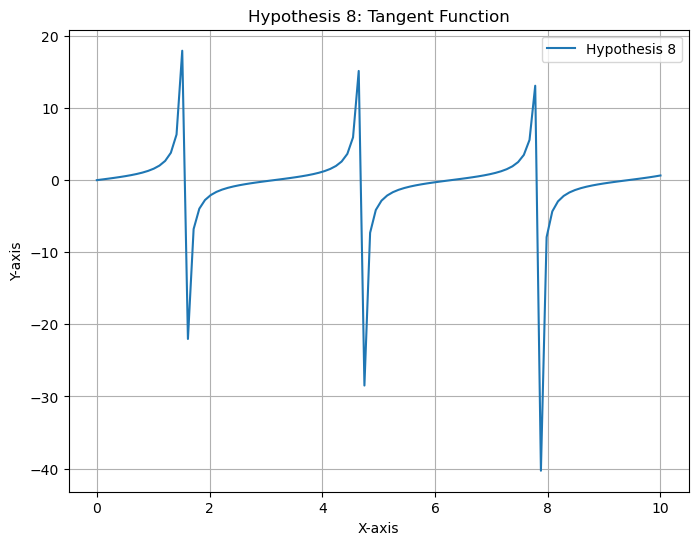

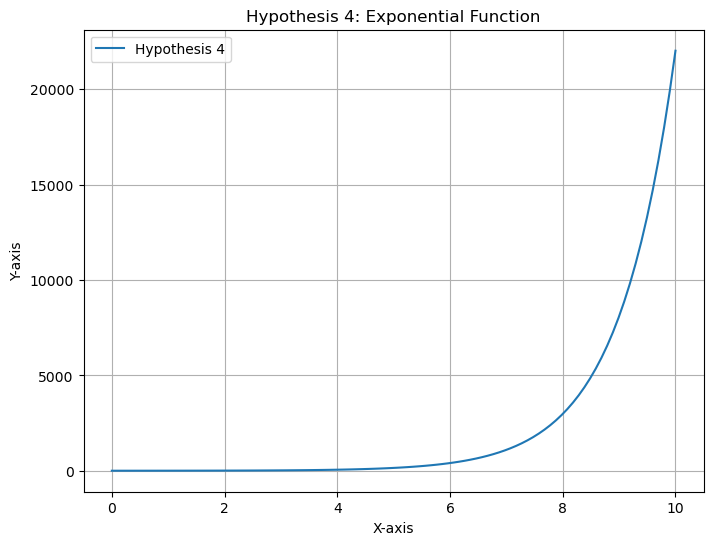

In [162]:
import easygui as eg
import matplotlib.pyplot as plt
import numpy as np

# Function to display a hypothesis plot based on the hypothesis number
def display_hypothesis_plot(hypothesis_number):
    # Placeholder data for each hypothesis (replace with actual data)
    x = np.linspace(0, 10, 100)

    if hypothesis_number == 1:
        y = np.sin(x)
        title = f'Hypothesis {hypothesis_number}: Sine Function'
    elif hypothesis_number == 2:
        y = np.cos(x)
        title = f'Hypothesis {hypothesis_number}: Cosine Function'
    elif hypothesis_number == 3:
        y = x
        title = f'Hypothesis {hypothesis_number}: Linear Function'
    elif hypothesis_number == 4:
        y = np.exp(x)
        title = f'Hypothesis {hypothesis_number}: Exponential Function'
    elif hypothesis_number == 5:
        y = np.log(x + 1)
        title = f'Hypothesis {hypothesis_number}: Logarithmic Function'
    elif hypothesis_number == 6:
        y = np.sqrt(x)
        title = f'Hypothesis {hypothesis_number}: Square Root Function'
    elif hypothesis_number == 7:
        y = x**2
        title = f'Hypothesis {hypothesis_number}: Quadratic Function'
    elif hypothesis_number == 8:
        y = np.tan(x)
        title = f'Hypothesis {hypothesis_number}: Tangent Function'
    elif hypothesis_number == 9:
        y = 1 / (x + 1)
        title = f'Hypothesis {hypothesis_number}: Rational Function'
    elif hypothesis_number == 10:
        y = np.sin(x) + np.cos(x)
        title = f'Hypothesis {hypothesis_number}: Sum of Sine and Cosine Functions'

    # Create and display the plot in a pop-up window
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, label=f'Hypothesis {hypothesis_number}')
    plt.title(title)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()
    plt.grid(True)
    plt.show(block=False)

# Create a function to show the hypothesis selection dialog
def select_hypothesis_plot():
    while True:
        msg = "Select a Hypothesis Plot to Display"
        title = "Hypothesis Selection"
        choices = [
            "Hypothesis 1", "Hypothesis 2", "Hypothesis 3", "Hypothesis 4", "Hypothesis 5",
            "Hypothesis 6", "Hypothesis 7", "Hypothesis 8", "Hypothesis 9", "Hypothesis 10", "Exit"
        ]

        choice = eg.choicebox(msg, title, choices=choices)

        if choice is None or choice == "Exit":
            break

        hypothesis_number = int(choice.split()[-1])  # Extract the hypothesis number
        display_hypothesis_plot(hypothesis_number)

# Show the hypothesis selection dialog
select_hypothesis_plot()